In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from math import pi

from src.CrI3.load_spe import load_spe
import scipy.constants as const
from src.CrI3.fit_lorentzian import fit_peak, lorentzian, voigt
# from ..utils_convolution import interp_nb
# from ..utils_general import get_I, get_I_conv

In [2]:
E_cutoff = 5.

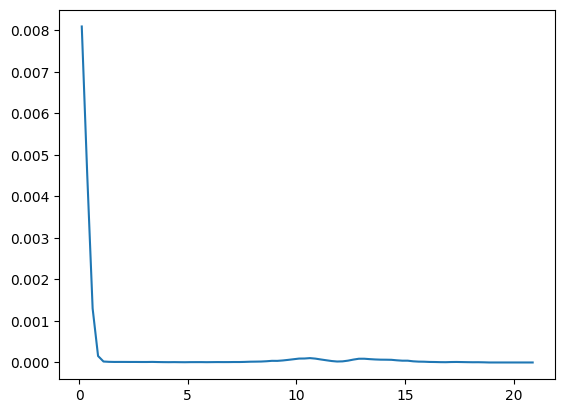

In [3]:
fname = 'src/CrI3/fig3a1.spe'
HH0_raw, E_raw, Z_raw, Err_raw = load_spe(fname)
idx_K = np.argmin(np.abs(HH0_raw + 1/3))

E_K, Intens_K = E_raw[E_raw>0], Z_raw[E_raw>0,idx_K]
plt.plot(E_K, Intens_K)

loss =  0.46977360002803814
loc: tensor([10.3513, 13.6543]) 
amp: tensor([ 9.3341, 11.3251], dtype=torch.float64) 
gamma: tensor([0.9277, 0.6444]) 
sigma: tensor([0.0447, 0.6929])


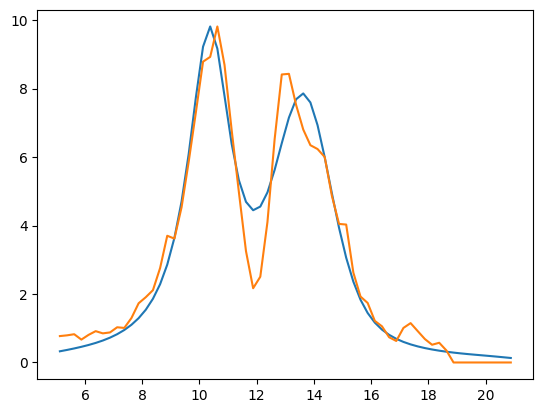

In [4]:
fname = 'src/CrI3/fig3a1.spe'
HH0_raw, E_raw, Z_raw, Err_raw = load_spe(fname)
idx_K = np.argmin(np.abs(HH0_raw + 1/3))

E_K, Intens_K = E_raw[E_raw>E_cutoff], Z_raw[E_raw>E_cutoff,idx_K]

param_X0, param_A, param_G, param_sigma = fit_peak(torch.from_numpy(E_K), torch.from_numpy(Intens_K), numIters=2000,mode='voigt')
Intens_K_fitted = voigt(torch.from_numpy(E_K), param_X0, param_A, param_G, param_sigma).detach().numpy()
plt.plot(E_K, Intens_K_fitted)
plt.plot(E_K, Intens_K / Intens_K.max() * Intens_K_fitted.max())
print('\nloc:', param_X0.squeeze(), '\namp:', param_A.squeeze(), '\ngamma:', param_G.squeeze(), '\nsigma:', param_sigma.squeeze())

/tmp/ipykernel_123660/1628667770.py:3: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(Z_raw), extent=[HH0_raw.min(), HH0_raw.max(), E_raw.min(), E_raw.max()],


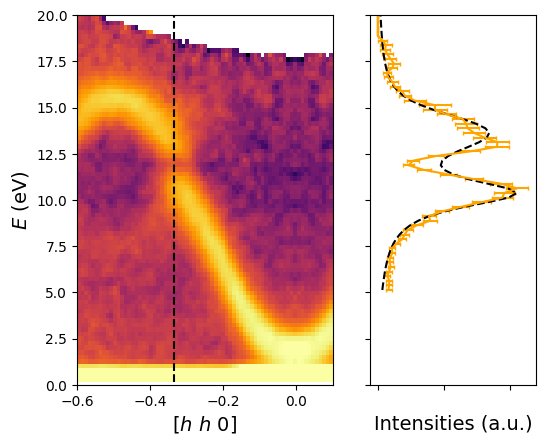

In [57]:
fig, axes = plt.subplots(1,2, sharey=True, gridspec_kw={'wspace': 0.0, 'width_ratios': [2, 1]})
ax = axes[0]
ax.imshow(np.log10(Z_raw), extent=[HH0_raw.min(), HH0_raw.max(), E_raw.min(), E_raw.max()], 
          origin='lower', cmap='inferno', vmax=-3.5)
ax.vlines(-1/3, E_raw.min(), E_raw.max(), linestyles='--', colors='k')
ax.set_aspect(1.5 * np.ptp(HH0_raw) / np.ptp(E_raw))
ax.set_xlabel('$[h\ h\ 0]$', fontsize=14)
ax.set_ylabel('$E$ (eV)', fontsize=14)
ax = axes[1]
ax.errorbar(Z_raw[E_raw>E_cutoff,idx_K], E_K, yerr=None, xerr=Err_raw[E_raw>E_cutoff, idx_K], 
            color='orange', ecolor='orange', capsize=1.2)
ax.plot(Intens_K_fitted / Intens_K_fitted.max() * Intens_K.max(), E_K, color='k', linestyle='--')
ax.set_xticklabels([])
ax.set_xlabel('Intensities (a.u.)', fontsize=14)
ax.set_ylim([0,20])
fig.align_labels()
fig.savefig('figures/CrI3/CrI3_neutron.pdf', bbox_inches='tight')

In [5]:
import sys
from src.utils_model import jit_batch_spec_to_Sqt

In [6]:
sigma_bkg = 1.0
w = torch.from_numpy(E_raw)
Sqw_bkg = 50 * torch.exp(-w.pow(2)/(2 * sigma_bkg**2)).detach().numpy()

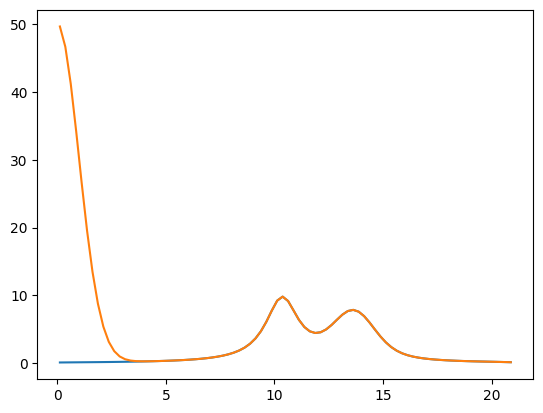

In [7]:
Sqw = voigt(w, param_X0, param_A, param_G, param_sigma).detach().numpy()
Sqw_tot = Sqw + Sqw_bkg
plt.plot(E_raw, Sqw)
plt.plot(E_raw, Sqw_tot)

In [8]:
Sqt = jit_batch_spec_to_Sqt(w, torch.from_numpy(Sqw), torch.linspace(0,5,501)).sum(dim=1).squeeze()
Sqt_bkg = jit_batch_spec_to_Sqt(w, torch.from_numpy(Sqw_bkg), torch.linspace(0,5,501)).sum(dim=1).squeeze()
Sqt_tot = jit_batch_spec_to_Sqt(w, torch.from_numpy(Sqw_tot), torch.linspace(0,5,501)).sum(dim=1).squeeze()

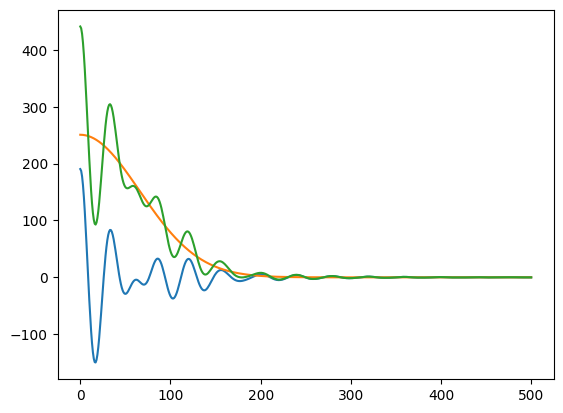

In [9]:
plt.plot(Sqt)
plt.plot(Sqt_bkg)
plt.plot(Sqt_tot)

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
from src.CrI3.prepare import prepare_CrI3_sample

(None,
 <function src.CrI3.prepare.prepare_CrI3_sample.<locals>.<lambda>(t)>,
 <function src.CrI3.prepare.prepare_CrI3_sample.<locals>.<lambda>(t)>)

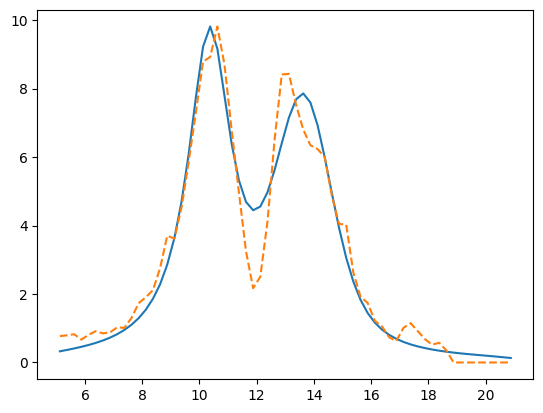

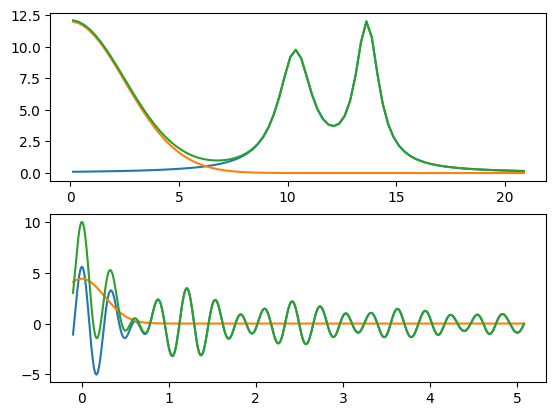

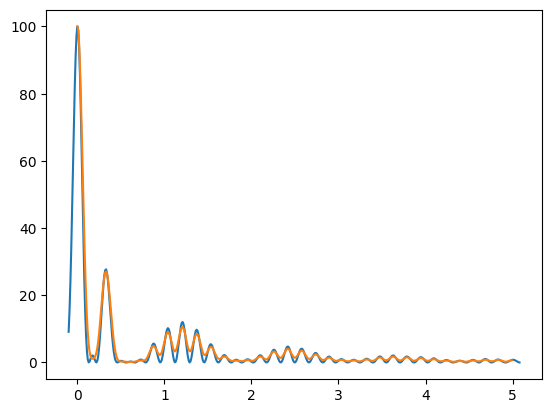

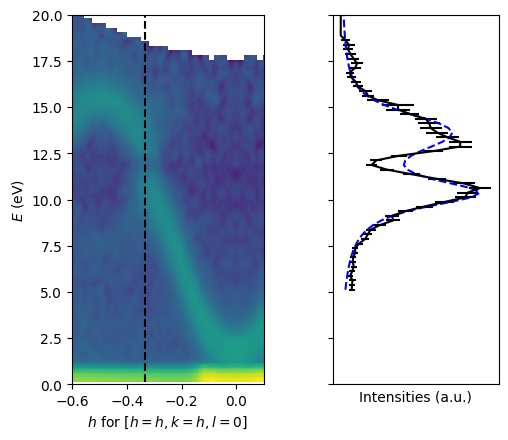

In [22]:
times = np.arange(0,5,0.01)
prepare_CrI3_sample(times, pulse_width=0.1, mode='voigt', E_cutoff=5.0,
                    amp_increase_factor=0.75, elas_bkg_amp_factor=1.0, elas_bkg_wid=2.5)